In [1]:
## This notebook describes how to use some basic functionalities of s4cmb such as
## * simulate an input sky
## * simulate an instrument 
## * simulate a scanning strategy
## * simulate TOD from the 3 previous guys
## * inject gain drifts
## * project back your TOD to sky maps.
import sys
import os
## Include your path to the package
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'../../s4cmb')))

In [2]:
## Import modules and routines
from s4cmb.input_sky import HealpixFitsMap

from s4cmb.instrument import Hardware

from s4cmb.scanning_strategy import ScanningStrategy

from s4cmb.tod import TimeOrderedDataPairDiff
from s4cmb.tod import OutputSkyMap
from s4cmb.tod import partial2full

from s4cmb.systematics import step_function
from s4cmb.systematics import linear_function

## Other packages needed
import healpy as hp
import pylab as pl
import numpy as np

try:
    from tqdm import *
except ImportError:
    tqdm = lambda x: x

In [3]:
#################################################################
## START OF THE SIMULATION 
## Flow is the following: 
##   sky -> instrument -> scanning strategy -> 
##   MAP2TOD -> Inject gain drifts -> TOD2MAP
##################################################################

In [4]:
## Initialise our input maps 
## (for test purposes, we create the maps on-the-fly from a CAMB file)
sky_in = HealpixFitsMap('../../s4cmb/s4cmb/data/test_data_set_lensedCls.dat', 
                        do_pol=True, fwhm_in=3.5, nside_in=512, 
                        map_seed=5843787, verbose=False, 
                        no_ileak=False, no_quleak=False)

In [5]:
## Initialise our instrument
## Generate a focal plane with 4 Crate boards, each with 1 MUX board, 
## each with 1 Squid, each with 16 pairs of bolometers.
## The focal plane is 60 cm wide (square),
## and each detector beam is Gaussian with FWHM of 3.5 arcmin.
## We choose a pointing model with 5 parameters.
## Finally, we mount a continously rotating HWP @ 2Hz on the instrument.
inst = Hardware(ncrate=4, ndfmux_per_crate=1,
                nsquid_per_mux=1, npair_per_squid=16,
                fp_size=60., fwhm=3.5, 
                beam_seed=58347, projected_fp_size=3., pm_name='5params',
                type_hwp='CRHWP', freq_hwp=2., angle_hwp=0., verbose=False)

In [6]:
## Initialize our scanning strategy
## Our scanning strategy will consist in scanning the Southern sky from Chile.
## We will perform 12 deep scan (CES) of roughly 4h.
## We will start the observation January, 1st 2013.
## We will set the sampling frequency of the detector to be 8 Hz, and we will 
## scan the sky at a speed of 0.4 deg/s.
scan = ScanningStrategy(nces=12, start_date='2013/1/1 00:00:00',
                        telescope_longitude='-67:46.816',
                        telescope_latitude='-22:56.396', telescope_elevation=5200.,
                        name_strategy='deep_patch', sampling_freq=8., sky_speed=0.4,
                        ut1utc_fn='../../s4cmb/s4cmb/data/ut1utc.ephem', 
                        language='fortran')
scan.run()

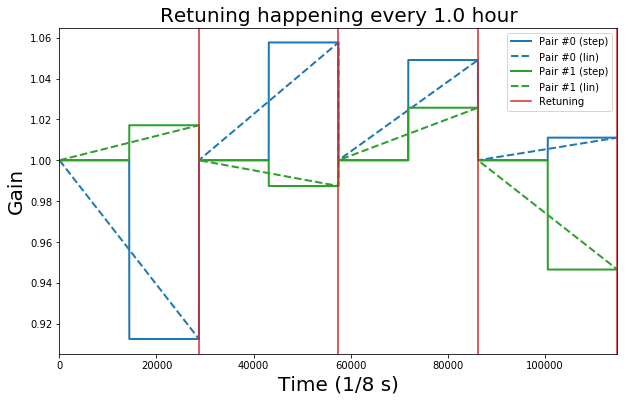

In [7]:
## Here is a simple example to illustrate how gains will be changed.

## We want to break the timestream every hour. One CES is 4 hours.
nts = 115000
nbreaks = 4

## We want to inject \pm 5% drift centered around gain=1.
## You have the choice in modeling the drifts as 
## step functions or linear functions.
## Let's show both on 4 bolometers (2 pairs).
gains_step = step_function(nbolos=4, 
                           nsamples=nts, 
                           mean=1, 
                           std=0.05, 
                           nbreaks=nbreaks, 
                           seed=100)
gains_lin = linear_function(nbolos=4, 
                            nsamples=nts, 
                            mean=1, 
                            std=0.05, 
                            nbreaks=nbreaks, 
                            seed=100)

## Plot gain drifts
pl.figure(figsize=(10, 6))
for i in range(0, len(gains_step), 2):
    pl.plot(gains_step[i], color='C{}'.format(i), 
            ls='-', lw=2,
            label='Pair #{} (step)'.format(i/2))
    pl.plot(gains_lin[i], color='C{}'.format(i), 
            ls='--', lw=2,
            label='Pair #{} (lin)'.format(i/2))

pl.xlabel('Time (1/8 s)', fontsize=20)
pl.ylabel('Gain', fontsize=20)
pl.title('Retuning happening every {:.1f} hour'.format(
        len(gains_step[0]) / 3600. / scan.sampling_freq /nbreaks),
        fontsize=20)

## Plot retuning points
count, ini_count = [nts // nbreaks] * 2
while count < nts:
    pl.axvline(count, ls='-', color='C3')
    count += ini_count
pl.axvline(count, ls='-', color='C3', label='Retuning')

pl.xlim(0, nts)
pl.legend()
pl.show()

In [8]:
## Let's now generate our TOD from our input sky, instrument, and scanning strategy
## Firts, we will use the difference of pairs of detectors to reconstruct 
## the polarisation (no demodulation).
## Once we will have the timestreams, we will reconstruct 
## our maps at a resolution nside = 512.

## MAP2TOD: scan the input sky to generate timestream channel-by-channel.
## this is currently the bottleneck in computation. 
## Need to speed-up this routine! (Hopefully everything is linear ;-) )
## This is where you want to parallelize for big runs, so that different processors 
## (or groups or procs) focus on different scans. Here is the serial version:
nside_out = 512

## Loop over scans
state = np.random.RandomState(0)
seeds_for_gain = state.randint(0, 1e6, scan.nces)
for CESnumber in range(scan.nces):
    tod = TimeOrderedDataPairDiff(inst, scan, sky_in, CESnumber=CESnumber, 
                                  projection='healpix', 
                                  nside_out=nside_out, 
                                  width=130.)
    
    ########################################################################
    ## Make new gain with 5% drift centered around 1, retuned every hour. ##
    ########################################################################
    new_gains = linear_function(2*tod.npair, tod.nsamples, 
                                mean=1., std=0.05, 
                                nbreaks=4, seed=seeds_for_gain[CESnumber])
    tod.set_detector_gains_pertimesample(new_gains=new_gains)
    
    ## Initialise map containers
    if CESnumber == 0:
        sky_out_tot = OutputSkyMap(projection=tod.projection, 
                                   nside=nside_out, 
                                   obspix=tod.obspix)
        
    ## Scan input map to get TODs
    d = np.array([
            tod.map2tod(det) for det in tqdm(
                range(inst.focal_plane.nbolometer))])
        
    ## Project TOD to maps
    tod.tod2map(d, sky_out_tot)

100%|██████████| 128/128 [00:09<00:00, 13.18it/s]


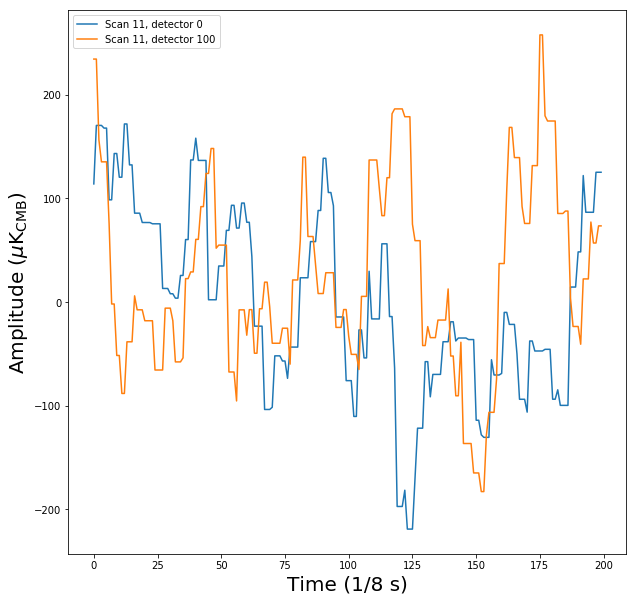

In [9]:
## Let's have a look at some TOD, that is 
## d(t) = I(t) + Q(t)cos(2*theta(t)) + U(t)sin(2*theta(t)).
## Keep in mind we set the sample rate at 8 Hz.
fig = pl.figure(figsize=(10, 10))
pl.plot(d[0][0:200], label='Scan 11, detector 0')
pl.plot(d[100][0:200], label='Scan 11, detector 100')
pl.legend()
pl.xlabel('Time (1/8 s)', fontsize=20)
pl.ylabel('Amplitude ($\mu$K$_{\\rm CMB}$)', fontsize=20)
pl.show()

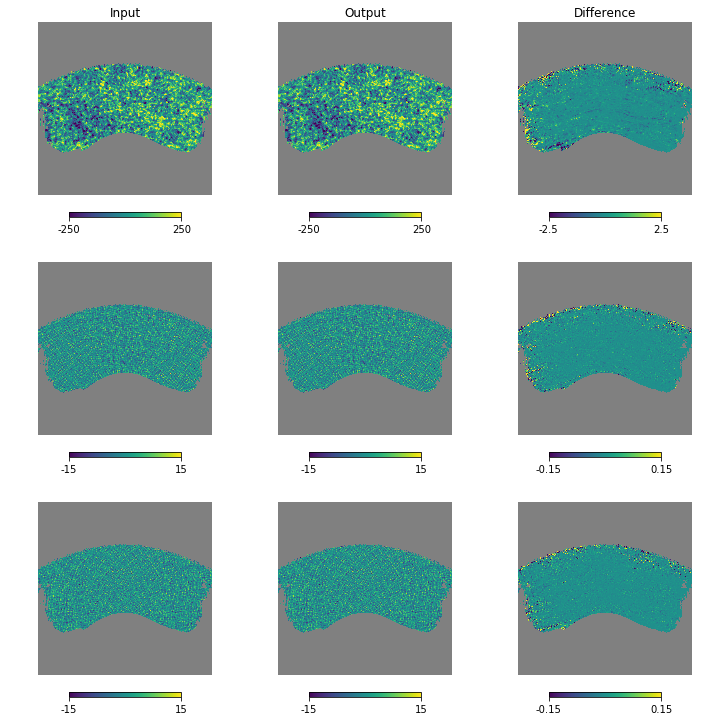

In [12]:
## In the absence of systematics, these operations should not change the 
## signal. Let's check that we did not harm the signal.
xsize = 700
fig = pl.figure(figsize=(10, 10))

nhit = partial2full(sky_out_tot.nhit, sky_out_tot.obspix, 
                       sky_out_tot.nside, fill_with=0.0)

## Temperature
sky_out = partial2full(sky_out_tot.get_I(), sky_out_tot.obspix, 
                       sky_out_tot.nside, fill_with=0.0)

mask = nhit < 1
sky_in.I[mask] = np.nan
sky_out[mask] = np.nan
hp.gnomview(sky_in.I, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=331, 
            title='Input', notext=True, min=-250, max=250)
hp.gnomview(sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=332, 
            title='Output', notext=True, min=-250, max=250)
hp.gnomview(sky_in.I - sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=333, 
            title='Difference', notext=True, min=-2.5, max=2.5)

## Stokes Q
sky_out = partial2full(sky_out_tot.get_QU()[0], sky_out_tot.obspix, 
                       sky_out_tot.nside, fill_with=0.0)
mask = nhit < 10
sky_in.Q[mask] = np.nan
sky_out[mask] = np.nan

hp.gnomview(sky_in.Q, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=334, 
            notext=True, min=-15, max=15, title='')
hp.gnomview(sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=335,  
            notext=True, min=-15, max=15, title='')
hp.gnomview(sky_in.Q - sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=336, 
            notext=True, title='', min=-0.15, max=0.15)

## Stokes U
sky_out = partial2full(sky_out_tot.get_QU()[1], sky_out_tot.obspix, 
                       sky_out_tot.nside, fill_with=0.0)
mask = nhit < 10
sky_in.U[mask] = np.nan
sky_out[mask] = np.nan
hp.gnomview(sky_in.U, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=337, 
            notext=True, min=-15, max=15, title='')
hp.gnomview(sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=338, 
            notext=True, min=-15, max=15, title='')
hp.gnomview(sky_in.U - sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=339, 
            notext=True, title='', min=-0.15, max=0.15)
pl.show()

In [11]:
## Note that we obtain a O(%) effect in the map (esp. at the edges) in this 
## simple example (few bolometers, O(5%) drifts retuned every hour).

## In this example we chose to use linear functions to model the drifts.
## We could imagine other behaviour... I let you do that in s4cmb/systematics.py!